In [35]:
!pip install mcap-ros2-support mcap

Defaulting to user installation because normal site-packages is not writeable


In [36]:
import math

In [53]:
from mcap_ros2.decoder import DecoderFactory
from mcap.reader import make_reader

magnetometer_data = []
printer_data = []
with open(
    "../data/rosbag2_2024_01_11-11_38_41/rosbag2_2024_01_11-11_38_41_0.mcap",
    "rb",
) as fd:
    reader = make_reader(fd, decoder_factories=[DecoderFactory()])
    for schema, channel, message, ros_msg in reader.iter_decoded_messages(
    ):
        # print(f"{channel.topic} {schema.name} [{message.log_time}]: ")
        if channel.topic == "/magnetometer_reading":
            for reading in ros_msg.magnetic_field_array:
                timestamp = reading.header.stamp.sec + reading.header.stamp.nanosec * 1e-9
                magnetic_field_x = reading.magnetic_field.x
                magnetic_field_y = reading.magnetic_field.y
                magnetic_field_z = reading.magnetic_field.z
                magnetometer_data.append([timestamp, magnetic_field_x, magnetic_field_y, magnetic_field_z])

        elif channel.topic == "/tf":
            for transform in ros_msg.transforms:
                if transform.header.frame_id == "printer_head_link":
                    timestamp = transform.header.stamp.sec + transform.header.stamp.nanosec * 1e-9
                    x = transform.transform.translation.x
                    y = transform.transform.translation.y
                    z = transform.transform.translation.z
                    printer_data.append([timestamp, x, y, z])

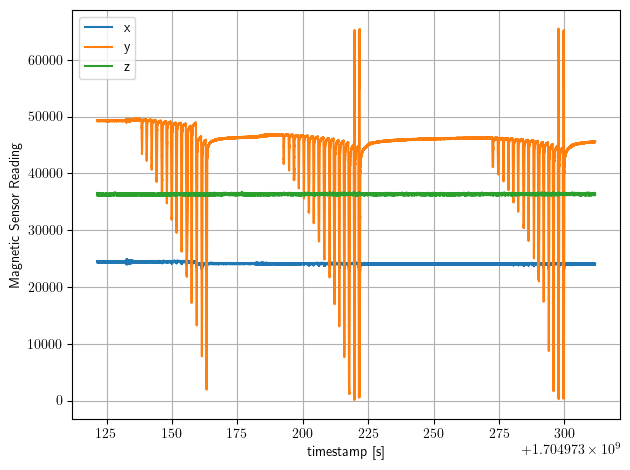

In [54]:
from matplotlib import pyplot as plt

plt.plot([x[0] for x in magnetometer_data], [x[1] for x in magnetometer_data], label="x")
plt.plot([x[0] for x in magnetometer_data], [x[2] for x in magnetometer_data], label="y")
plt.plot([x[0] for x in magnetometer_data], [x[3] for x in magnetometer_data], label="z")
plt.gca().set_xlabel("timestamp [s]")
plt.gca().set_ylabel("Magnetic Sensor Reading")
plt.legend()
plt.grid()
plt.tight_layout()
plt.gcf().savefig("../../reports/ros_integration/figures/raw_magnetometer.png")

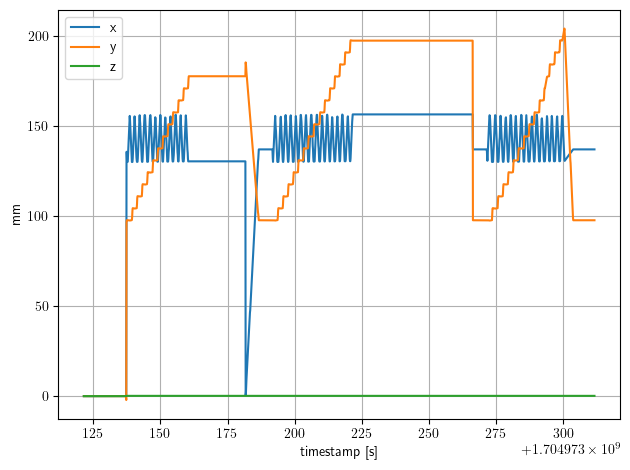

In [55]:
plt.plot([x[0] for x in printer_data], [x[1] for x in printer_data], label="x")
plt.plot([x[0] for x in printer_data], [x[2] for x in printer_data], label="y")
plt.plot([x[0] for x in printer_data], [x[3] for x in printer_data], label="z")
plt.gca().set_xlabel("timestamp [s]")
plt.gca().set_ylabel("mm")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("../../reports/ros_integration/figures/3d_printer_raw.png")


In [56]:
import numpy as np
from scipy.signal import butter,filtfilt

# Filter requirements.
T = 5.0         # Sample Period
fs = 850       # sample rate, Hz
cutoff = 5     # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
# n = len(y_data) # total number of samples

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # print(b.dtype, a.dtype)
    y = filtfilt(b, a, data)
    return y

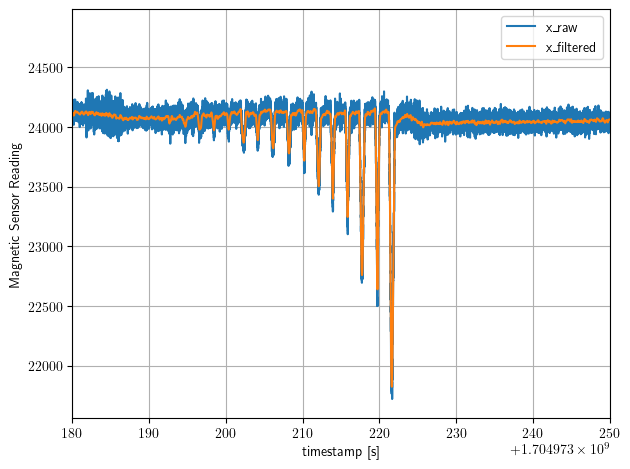

In [57]:
t_data = [x[0] for x in magnetometer_data]
x_data = [x[1] for x in magnetometer_data]
x_filtered = butter_lowpass_filter(x_data, cutoff, fs, order)

plt.plot(t_data, x_data, label="x_raw")
plt.plot(t_data, x_filtered, label="x_filtered")
plt.gca().set_xlabel("timestamp [s]")
plt.gca().set_ylabel("Magnetic Sensor Reading")
plt.xlim([x + 1.704973e9 for x in (180, 250)])
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("../../reports/ros_integration/figures/filtered_magnetometer.png")

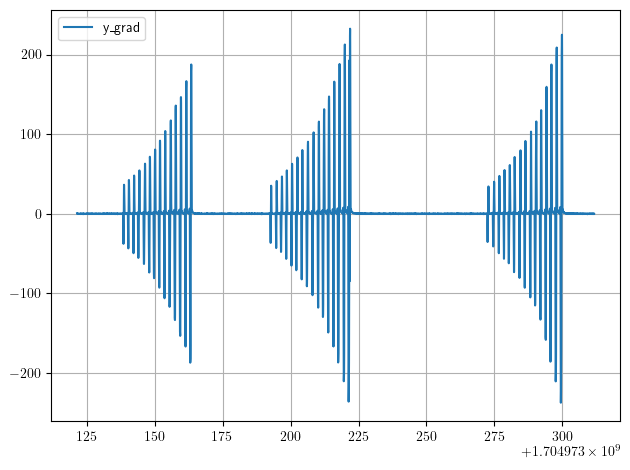

In [58]:
# get gradient of sensor data
import numpy as np

y_data = [float(x[2]) for x in magnetometer_data]
for i in range(len(y_data)):
    if y_data[i] > 55000:
        y_data[i] = y_data[i] - 2**16
y_filtered = butter_lowpass_filter(y_data, cutoff, fs, order)
y_grad = np.gradient(y_filtered)

plt.plot([x[0] for x in magnetometer_data], y_grad, label="y_grad")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("../../reports/ros_integration/figures/y_grad.png")


In [59]:
def split_into_episodes(y_grad, t_data):
    episodes = []
    open_episode = True
    episode_start = 0


    print(len(y_grad), len(t_data))
    for idx, pt in enumerate(y_grad):
        if open_episode:
            if pt < -10:
                # found start of episode
                open_episode = False
                episode_start = t_data[idx]
            else:
                continue
        else:
            if pt > 10:
                # found end of episode
                open_episode = True
                episodes.append((episode_start, t_data[idx]))
            else:
                continue
    return episodes

t_data = [x[0] for x in magnetometer_data]
episodes = split_into_episodes(y_grad, t_data)

169063 169063


/home/liyouzhou/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/liyouzhou/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


46
[144.10500000000002, 137.445, 130.78, 124.105, 117.455, 110.75, 104.10000000000001, 97.41999999999999, 90.75500000000001, 84.09500000000001, 77.44, 70.75999999999999, 63.94, 63.94, 144.115, 137.44, 130.78, 124.11, 117.44, 110.78500000000001, 104.11000000000001, 97.455, 90.78500000000001, 84.09, 77.44500000000001, 70.76, 64.09500000000001, 57.44999999999999, 50.765, 44.105000000000004, nan, 144.13, 137.47, 130.775, 124.105, 117.46, 110.78, 104.12, 97.44, 90.76, 84.105, 77.44, 65.99000000000001, 57.43000000000001, 50.765, 44.09]
[-37.7228814629234, -43.45072066251669, -49.52438773133326, -55.4304777897305, -63.04867287203524, -73.76938856942434, -80.97711360104222, -92.83408591477564, -106.14408955821636, -116.9042214092733, -133.53397459087682, -153.40242484247028, -166.86591889249758, -187.1140557336348, -36.51863072086053, -43.05953214929832, -47.91386651775247, -56.63815426142537, -65.13632394608067, -70.96183592489251, -82.40259554018121, -91.09326617615443, -102.33808650406718, 

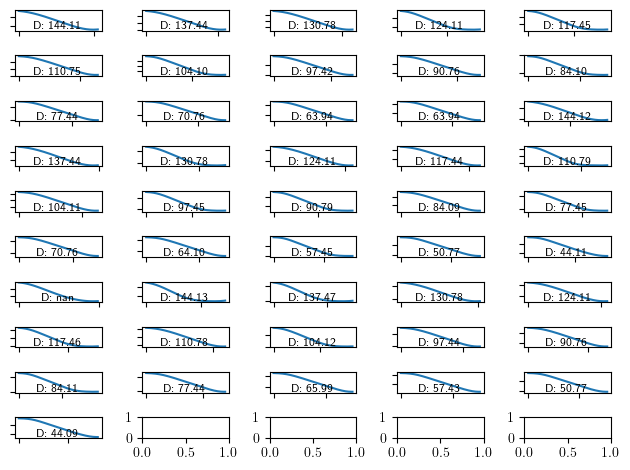

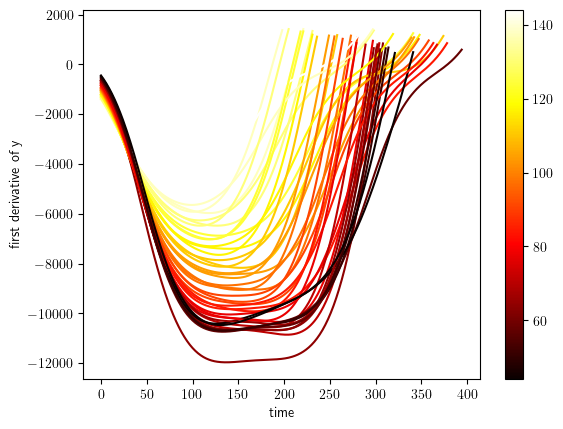

In [81]:

BEAM_EDGE_Y_RELATIVE_TO_NOZZLE = 56.75
WHISKER_TIP_Y = 35  # from the base of the printer bed


def distance_on_shaft(y):
    return 150 - (y - BEAM_EDGE_Y_RELATIVE_TO_NOZZLE - WHISKER_TIP_Y)


def get_episode_data(episodes, printer_data, y_filtered, t_data, y_grad):
    shaft_timestamp = [x[0] for x in printer_data]
    shaft_data = [distance_on_shaft(x[2]) for x in printer_data]

    shaft_data_zipped = list(zip(shaft_timestamp, shaft_data))
    shaft_data_per_episode = []

    episodes_data = []
    episodes_grad_data = []
    for episode_start, episode_end in episodes:
        episodes_data.append(
            [y for t, y in zip(t_data, y_filtered) if t >= episode_start and t <= episode_end]
        )
        shaft_data_per_episode.append(
            [
                x[1]
                for x in shaft_data_zipped
                if x[0] >= episode_start and x[0] <= episode_end
            ]
        )
        episodes_grad_data.append(
            [y for t, y in zip(t_data, y_grad) if t >= episode_start and t <= episode_end]
        )

    shaft_distance_per_episode = [float(np.median(x)) for x in shaft_data_per_episode]

    return episodes_data, episodes_grad_data, shaft_distance_per_episode

episodes_data, episodes_grad_data, shaft_distance_per_episode = get_episode_data(episodes, printer_data, y_filtered, t_data, y_grad)
print(len(episodes_data))
fig, axes = plt.subplots(ncols=5, nrows=math.ceil(len(episodes) / 5))
for idx, data in enumerate(episodes_data):
    ax = axes[idx // 5, idx % 5]
    ax.plot(data)
    ax.set_title(
        f"D: {shaft_distance_per_episode[idx]:.2f}", y=1.0, pad=-14, fontsize=8
    )

    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
plt.tight_layout()
plt.savefig("../../reports/ros_integration/figures/episodes_y_data.png")

# fig, axes = plt.subplots(ncols=5, nrows=math.ceil(len(episodes) / 5))
# for idx, data in enumerate(episodes_grad_data):
#     ax = axes[idx // 5, idx % 5]
#     ax.plot(data)
#     ax.set_title(f"D: {shaft_distance_per_episode[idx]:.2f}")

#     ax.axes.xaxis.set_ticklabels([])
#     ax.axes.yaxis.set_ticklabels([])
import matplotlib as mpl
import matplotlib.cm as cm

norm = mpl.colors.Normalize(
    vmin=min(shaft_distance_per_episode), vmax=max(shaft_distance_per_episode)
)
cmap = cm.hot
x = 0.3

m = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure()
for idx, data in enumerate(episodes_grad_data):
    d = shaft_distance_per_episode[idx]
    plt.plot(
        [data*d for data in data],
        label=f"{d:.2f}",
        color=m.to_rgba(d),
    )

plt.rcParams['text.usetex'] = True
plt.gca().set_xlabel("time")
plt.gca().set_ylabel("first derivative of y")
plt.colorbar(m, ax=plt.gca())
# plt.tight_layout()
plt.savefig("../../reports/ros_integration/figures/corrected_derivative.png")

max_grad_per_episode = [np.min(x) for x in episodes_grad_data]
print(shaft_distance_per_episode)
print(max_grad_per_episode)

46 46
[211, 222, 232, 342, 349, 259, 343, 274, 281, 379, 298, 305, 302, 309, 189, 199, 299, 222, 232, 375, 250, 348, 359, 275, 368, 290, 299, 395, 315, 342, 50, 288, 298, 206, 219, 320, 237, 340, 256, 265, 364, 280, 303, 306, 312, 322]


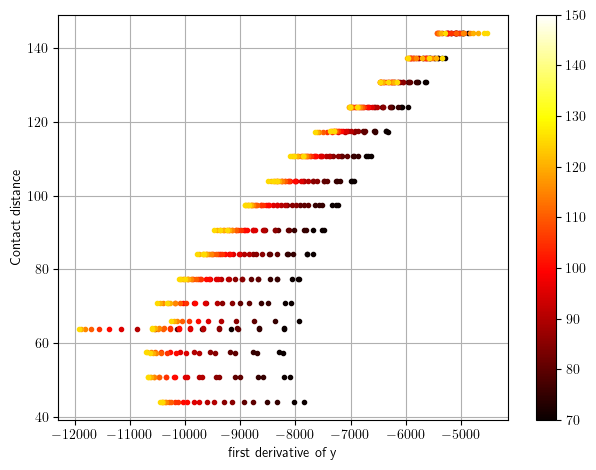

In [74]:
tenth_grad_per_episode = [x[10] for x in episodes_grad_data]

print(len(shaft_distance_per_episode), len(tenth_grad_per_episode))

norm = mpl.colors.Normalize(
    vmin=70, vmax=150
)
cmap = cm.hot
m = cm.ScalarMappable(norm=norm, cmap=cmap)

print(list([len(x) for x in episodes_grad_data]))


for n in range(70,130,5):
    nth_grad_per_episode = [x[min(n, len(x)-1)] for x in episodes_grad_data]
    zipped_nth_grad_per_episode = zip(nth_grad_per_episode,shaft_distance_per_episode.copy())

    zipped_nth_grad_per_episode = sorted(zipped_nth_grad_per_episode, key=lambda x: x[1])

    plt.plot([x*d for x,d in zipped_nth_grad_per_episode], [d for _,d in zipped_nth_grad_per_episode], ".", color=m.to_rgba(n))


plt.colorbar(m, ax=plt.gca())
plt.xlabel("first derivative of y")
plt.ylabel("Contact distance")
plt.grid()
plt.tight_layout()
plt.savefig("../../reports/ros_integration/figures/x_y_relationship.png")



[-10418.373246243442, -10397.149471250936, -10632.731258157892, -10627.613769204665, -10591.0640911716, -10682.192620107022, -10557.90780366943, -11882.523618476442, -10553.49650974022, -10206.456741548891, -10459.6099364968, -10265.537996923082, -10080.27007885392, -10037.107412602843, -9952.213861773802, -9614.21011423638, -9740.218511526571, -9620.037791449335, -9425.647656125253, -9312.141919544301, -9207.381630539612, -8894.970328184314, -8856.515958066702, -8812.14699711977, -8371.790537533401, -8446.585022370064, -8303.640997253864, -7964.274876855108, -8069.488624218169, -7838.377916092612, -7613.700833847302, -7362.12778208567, -7302.7357567618965, -6863.284505571319, -7015.051084451765, -7028.418376990211, -6404.800817162569, -6466.182121186877, -6214.391318460857, -5711.170364398741, -5970.648149038391, -5451.529991704069, -5358.647029004896, -4788.670157986087, nan, -4690.721010879276] [44.09, 44.105000000000004, 50.765, 50.765, 57.43000000000001, 57.44999999999999, 63.94, 

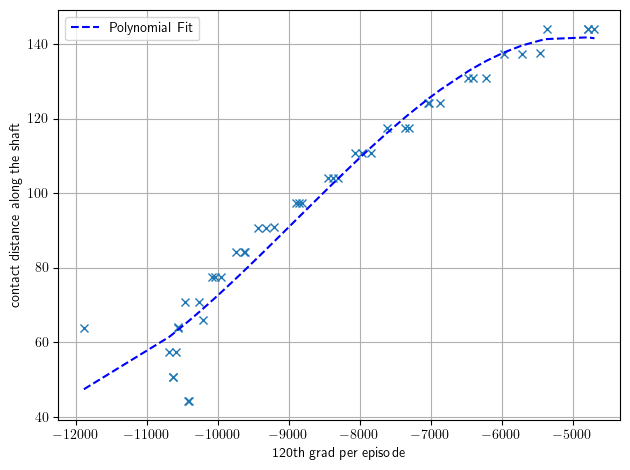

In [76]:
from scipy.optimize import curve_fit

def whisker_model(x, a, b, c, d):
    return a*x*x*x + b*x*x + c*x + d

nth_grad_per_episode = [x[min(120, len(x)-1)] for x in episodes_grad_data]
zipped_nth_grad_per_episode = zip(nth_grad_per_episode,shaft_distance_per_episode.copy())
zipped_nth_grad_per_episode = sorted(zipped_nth_grad_per_episode, key=lambda x: x[1])
x_data = [x * d for x,d in zipped_nth_grad_per_episode]
y_data = [d for x,d in zipped_nth_grad_per_episode]
print(x_data, y_data)

for idx,x in enumerate(x_data):
    if np.isnan(x):
        x_data[idx] = x_data[idx-1]
        y_data[idx] = y_data[idx-1]

param, param_cov = curve_fit(whisker_model, x_data, y_data)
plt.plot(x_data, y_data, "x")

plt.grid()

ans = [whisker_model(x, param[0], param[1], param[2], param[3]) for x in sorted(x_data)]

plt.plot(sorted(x_data), ans, '--', color ='blue', label ="Polynomial Fit")
plt.gca().set(xlabel='120th grad per episode', ylabel='contact distance along the shaft')
plt.legend()
plt.tight_layout()
plt.savefig("../../reports/ros_integration/figures/polynomial_regression.png")


In [77]:
import pickle

with open("whisker_model.pkl", "wb") as fd:
    pickle.dump(param, fd)
with open("whisker_model.pkl", "rb") as fd:
    print(pickle.load(fd))

[-4.12174525e-10 -1.09993840e-05 -7.89612426e-02 -2.93621783e+01]


In [100]:
def read_data(path):
    mag_data = []
    pri_data = []
    with open(path, "rb") as fd:
        reader = make_reader(fd, decoder_factories=[DecoderFactory()])
        for schema, channel, message, ros_msg in reader.iter_decoded_messages():
            # print(f"{channel.topic} {schema.name} [{message.log_time}]: ")
            if channel.topic == "/magnetometer_reading":

                # print(f"found magnetometer data {len(ros_msg.magnetic_field_array)}")
                for reading in ros_msg.magnetic_field_array:
                    timestamp = (
                        reading.header.stamp.sec + reading.header.stamp.nanosec * 1e-9
                    )
                    magnetic_field_x = reading.magnetic_field.x
                    magnetic_field_y = reading.magnetic_field.y
                    magnetic_field_z = reading.magnetic_field.z
                    mag_data.append(
                        [
                            timestamp,
                            magnetic_field_x,
                            magnetic_field_y,
                            magnetic_field_z,
                        ]
                    )

            elif channel.topic == "/tf":
                for transform in ros_msg.transforms:
                    if transform.header.frame_id == "printer_head_link":
                        timestamp = (
                            transform.header.stamp.sec
                            + transform.header.stamp.nanosec * 1e-9
                        )
                        x = transform.transform.translation.x
                        y = transform.transform.translation.y
                        z = transform.transform.translation.z
                        pri_data.append([timestamp, x, y, z])
    return mag_data, pri_data


from glob import glob

paths = glob("../data/petg_*/*.mcap")
path = paths[0]
petg_mag_data, petg_pri_data = read_data(path)
print(len(petg_mag_data), len(petg_pri_data))
petg_y_data = [float(x[2]) for x in petg_mag_data][10500:]
for idx in range(1, len(petg_y_data)):
    if np.abs(petg_y_data[idx] - petg_y_data[idx-1]) > np.abs(petg_y_data[idx] + 65536 - petg_y_data[idx-1]):
        petg_y_data[idx] = petg_y_data[idx] + 65536
print(path, len(petg_y_data))
petg_y_filtered = butter_lowpass_filter(petg_y_data, cutoff, fs, order)
petg_y_grad = np.gradient(petg_y_filtered)
petg_t_data = [x[0] for x in petg_mag_data][10500:]
petg_eps = split_into_episodes(petg_y_grad, petg_t_data)
petg_eps_data, petg_eps_grad_data, petg_shaft_d_per_eps = get_episode_data(
    petg_eps, petg_pri_data, petg_y_filtered, petg_t_data, petg_y_grad
)

42067 504
../data/petg_5mm_150mm_30fill/petg_5mm_150mm_0.mcap 31567
31567 31567


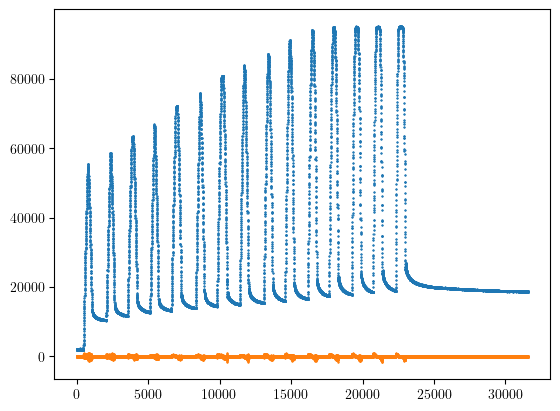

In [101]:
plt.plot(petg_y_data, ".", markersize=1)
plt.plot(np.gradient(petg_y_data), ".", markersize=1)

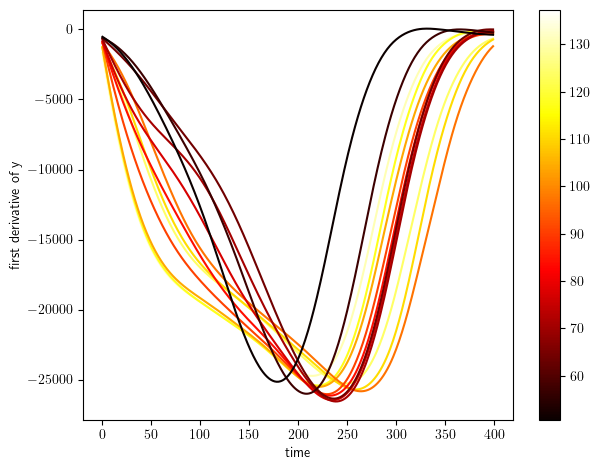

In [105]:
norm = mpl.colors.Normalize(
    vmin=min(petg_shaft_d_per_eps), vmax=max(petg_shaft_d_per_eps)
)
cmap = cm.hot
m = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure()
for idx, data in enumerate(petg_eps_grad_data):
    d = petg_shaft_d_per_eps[idx]
    plt.plot(
        [data*d for data in data][:400],
        label=f"{d:.2f}",
        color=m.to_rgba(d),
    )

plt.rcParams['text.usetex'] = True
plt.gca().set_xlabel("time")
plt.gca().set_ylabel("first derivative of y")
plt.colorbar(m, ax=plt.gca())
plt.tight_layout()
plt.savefig("../../reports/ros_integration/figures/pteg_episodes.png")

# max_grad_per_episode = [np.min(x) for x in episodes_grad_data]
# print(shaft_distance_per_episode)
# print(max_grad_per_episode)

# fig = plt.figure()

# norm = mpl.colors.Normalize(
#     vmin=10, vmax=20
# )
# cmap = cm.hot
# m = cm.ScalarMappable(norm=norm, cmap=cmap)

# print(list([len(x) for x in episodes_grad_data]))


# for n in range(10,11):
#     nth_grad_per_episode = [x[min(n, len(x)-1)] for x in episodes_grad_data]
#     zipped_nth_grad_per_episode = zip(nth_grad_per_episode,shaft_distance_per_episode.copy())

#     zipped_nth_grad_per_episode = sorted(zipped_nth_grad_per_episode, key=lambda x: x[1])

#     plt.plot([x/d for x,d in zipped_nth_grad_per_episode], [d for _,d in zipped_nth_grad_per_episode], ".", color=m.to_rgba(n))



# episodes_data, episodes_grad_data, shaft_distance_per_episode